# ノック21 : データ読み込み、確認

In [1]:
import pandas as pd
uselog = pd.read_csv('use_log.csv')
print(len(uselog))
uselog.head()

197428


,log_id,customer_id,usedate
0,L00000049012330,AS009373,2018-04-01
1,L00000049012331,AS015315,2018-04-01
2,L00000049012332,AS040841,2018-04-01
3,L00000049012333,AS046594,2018-04-01
4,L00000049012334,AS073285,2018-04-01


In [2]:
customer = pd.read_csv('customer_master.csv')
print(len(customer))
customer.head()

4192


,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaN,CA1,0


In [3]:
class_master = pd.read_csv('class_master.csv')
print(len(class_master))
class_master.head()

3


,class,class_name,price
0,C01,オールタイム,10500
1,C02,デイタイム,7500
2,C03,ナイト,6000


In [4]:
campaign_master = pd.read_csv('campaign_master.csv')
print(len(campaign_master))
campaign_master.head()

3


,campaign_id,campaign_name
0,CA1,通常
1,CA2,入会費半額
2,CA3,入会費無料


# ノック22 : データ整形

In [5]:
customer_join = pd.merge(customer, class_master, on = 'class', how = 'left')
customer_join = pd.merge(customer_join, campaign_master, on = 'campaign_id', how='left')
customer_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0,オールタイム,10500,通常
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0,オールタイム,10500,通常
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0,オールタイム,10500,通常
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0,オールタイム,10500,通常
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaN,CA1,0,ナイト,6000,通常


In [6]:
customer_join.isnull().sum()

# missing data are only in end_date
# end_date means date leaving from service
# so the customers who have end_date already left gym

customer_id         0
name                0
class               0
gender              0
start_date          0
end_date         2842
campaign_id         0
is_deleted          0
class_name          0
price               0
campaign_name       0
dtype: int64

# ノック23 : 基礎集計

In [7]:
customer_join.groupby('class_name').count()['customer_id']

class_name
オールタイム    2045
デイタイム     1019
ナイト       1128
Name: customer_id, dtype: int64

In [8]:
customer_join.groupby('campaign_name').count()['customer_id']

campaign_name
入会費半額     650
入会費無料     492
通常       3050
Name: customer_id, dtype: int64

In [9]:
customer_join.groupby('gender').count()['customer_id']

gender
F    1983
M    2209
Name: customer_id, dtype: int64

In [10]:
customer_join.groupby('is_deleted').count()['customer_id']

is_deleted
0    2842
1    1350
Name: customer_id, dtype: int64

In [11]:
customer_join['start_date'] = pd.to_datetime(customer_join['start_date'])                      # convert 'start_date' to datetime format 
customer_start = customer_join.loc[customer_join['start_date'] > pd.to_datetime('20180401')]   # extract customers who joined the gym after 20180401 because campaign3 started from 20180401
print(len(customer_start))

1361


In [12]:
# additional analysis 1
# cross table campaign x gender
customer_join.pivot_table(index = 'campaign_id',
                          columns = 'gender',
                          aggfunc = 'size')

gender,F,M
campaign_id,,
CA1,1446,1604
CA2,286,364
CA3,251,241


In [13]:
# additional analysis 2
# cross table campaign x is_deleted
customer_join.pivot_table(index = 'campaign_id',
                          columns = 'is_deleted',
                          aggfunc = 'size')

# number of customers who joined with campaign is larger than without campaign

is_deleted,0,1
campaign_id,,
CA1,2341,709
CA2,282,368
CA3,219,273


# ノック24 : 最新月の基礎集計

In [14]:
# additional analysis 3
# end_date and is_deleted flag are really same?
customer_join.pivot_table(index = 'end_date',
                          columns = 'is_deleted',
                          aggfunc = 'size')

is_deleted,1
end_date,
2018-04-30 00:00:00,121
2018-05-31 00:00:00,125
2018-06-30 00:00:00,106
2018-07-31 00:00:00,102
2018-08-31 00:00:00,113
2018-09-30 00:00:00,104
2018-10-31 00:00:00,90
2018-11-30 00:00:00,89
2018-12-31 00:00:00,111


In [15]:
customer_join['end_date'] = pd.to_datetime(customer_join['end_date'])
customer_newer = customer_join.loc[(customer_join['end_date'] >= pd.to_datetime('20190331')) | (customer_join['end_date'].isna())]
print(len(customer_newer))
customer_newer['end_date'].unique()

2953


array([                          'NaT', '2019-03-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [16]:
customer_newer.groupby('class_name').count()['customer_id']

class_name
オールタイム    1444
デイタイム      696
ナイト        813
Name: customer_id, dtype: int64

In [17]:
customer_newer.groupby('campaign_name').count()['customer_id']

campaign_name
入会費半額     311
入会費無料     242
通常       2400
Name: customer_id, dtype: int64

In [18]:
customer_newer.groupby('gender').count()['customer_id']

gender
F    1400
M    1553
Name: customer_id, dtype: int64

# ノック25 : 利用履歴の集計

In [19]:
uselog['usedate'] = pd.to_datetime(uselog['usedate'])
uselog['年月'] = uselog['usedate'].dt.strftime('%Y%m')   # it is not good to use 2bytes character as variable name
uselog_months = uselog.groupby(['年月', 'customer_id'], as_index = False).count()
uselog_months.rename(columns = {'log_id':'count'}, inplace = True)   # if inplace is true, original dataframe is update
del uselog_months['usedate']
uselog_months.head(10)

,年月,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7
5,201804,AS015746,4
6,201804,AS019860,6
7,201804,AS024181,4
8,201804,AS030404,1
9,201804,AS031206,4


In [20]:
uselog_customer = uselog_months.groupby('customer_id').agg(['mean', 'median', 'max', 'min'])['count']
uselog_customer = uselog_customer.reset_index(drop=False)
uselog_customer.head()

# refer URL below for agg method
# https://note.nkmk.me/python-pandas-agg-aggregate/

,customer_id,mean,median,max,min
0,AS002855,4.500000,5.0,7,2
1,AS008805,4.000000,4.0,8,1
2,AS009013,2.000000,2.0,2,2
3,AS009373,5.083333,5.0,7,3
4,AS015233,7.545455,7.0,11,4


# ノック26 : 定期利用フラグ

- 最大値が4以上の曜日が一か月以上あるユーザをフラグ1とする

In [22]:
uselog['weekday'] = uselog['usedate'].dt.weekday  # add weekday flag

# count visit weekday for each customer and each visit year_month
uselog_weekday = uselog.groupby(['customer_id', '年月', 'weekday'], as_index = False).count()[['customer_id', '年月', 'weekday', 'log_id']]
uselog_weekday.rename(columns={'log_id':'count'}, inplace = True)
uselog_weekday.head()

,customer_id,年月,weekday,count
0,AS002855,201804,5,4
1,AS002855,201805,2,1
2,AS002855,201805,5,4
3,AS002855,201806,5,5
4,AS002855,201807,1,1


In [24]:
# add flag

# extract max count for each customer
uselog_weekday = uselog_weekday.groupby('customer_id', as_index = False).max()[['customer_id', 'count']]

# set routine_flg for all customers to 0
uselog_weekday['routine_flg'] = 0

# set routine_flg to 1 for customer whose count >4
## please be carefull a little bit to use where method
## the second argument will be input to the value when the condition in first argument is False
## https://note.nkmk.me/python-pandas-where-mask/
uselog_weekday['routine_flg'] = uselog_weekday['routine_flg'].where(uselog_weekday['count']<4, 1)
uselog_weekday.head()

,customer_id,count,routine_flg
0,AS002855,5,1
1,AS008805,4,1
2,AS009013,2,0
3,AS009373,5,1
4,AS015233,5,1


# ノック27 : 結合

In [25]:
customer_join = pd.merge(customer_join, uselog_customer, on = 'customer_id', how = 'left')
customer_join = pd.merge(customer_join, uselog_weekday[['customer_id', 'routine_flg']], on = 'customer_id', how= 'left')
customer_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.833333,5.0,8,2,1
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,5.083333,5.0,7,3,1
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.583333,5.0,6,3,1
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.833333,4.5,7,2,1
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,ナイト,6000,通常,3.916667,4.0,6,1,1


In [26]:
# check missing data
customer_join.isnull().sum()

customer_id         0
name                0
class               0
gender              0
start_date          0
end_date         2842
campaign_id         0
is_deleted          0
class_name          0
price               0
campaign_name       0
mean                0
median              0
max                 0
min                 0
routine_flg         0
dtype: int64

# ノック28 : 会員期間を算出

In [28]:
# load package
from dateutil.relativedelta import relativedelta

In [30]:
customer_join['calc_date'] = customer_join['end_date']
customer_join['calc_date'] = customer_join['calc_date'].fillna(pd.to_datetime('20190430'))  # fill na by 20190430
customer_join['membership_period'] = 0  # initialize the period
for i in range(len(customer_join)):
    delta = relativedelta(customer_join['calc_date'].iloc[i], customer_join['start_date'].iloc[i])
    customer_join['membership_period'].iloc[i] = delta.years*12 + delta.months
customer_join.head()

C:\Users\YusukeSato\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.833333,5.0,8,2,1,2019-04-30,47
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,5.083333,5.0,7,3,1,2019-04-30,47
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.583333,5.0,6,3,1,2019-04-30,47
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.833333,4.5,7,2,1,2019-04-30,47
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,ナイト,6000,通常,3.916667,4.0,6,1,1,2019-04-30,47


In [31]:
# test
# relativedelta cannot handle Series data, so the original code used for loop
relativedelta(customer_join['calc_date'], customer_join['start_date'])

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

# ノック29 : 要約統計量

In [32]:
customer_join[['mean', 'median', 'max', 'min']].describe()

,mean,median,max,min
count,4192.000000,4192.000000,4192.000000,4192.000000
mean,5.333127,5.250596,7.823950,3.041269
std,1.777533,1.874874,2.168959,1.951565
min,1.000000,1.000000,1.000000,1.000000
25%,4.250000,4.000000,7.000000,2.000000
50%,5.000000,5.000000,8.000000,3.000000
75%,6.416667,6.500000,9.000000,4.000000
max,12.000000,12.000000,14.000000,12.000000


In [33]:
customer_join.groupby('routine_flg').count()['customer_id']

routine_flg
0     779
1    3413
Name: customer_id, dtype: int64

(array([857., 774., 395., 368., 311., 331., 323., 237., 288., 308.]),
 array([ 1. ,  5.6, 10.2, 14.8, 19.4, 24. , 28.6, 33.2, 37.8, 42.4, 47. ]),
 <BarContainer object of 10 artists>)

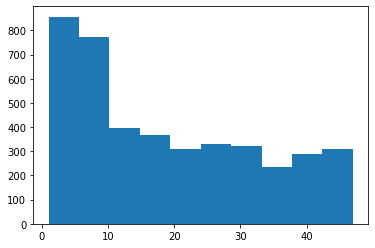

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(customer_join['membership_period'])

# ノック30 : 違いを把握

In [35]:
customer_end = customer_join.loc[customer_join['is_deleted'] == 1]
customer_end.describe()

,is_deleted,price,mean,median,max,min,routine_flg,membership_period
count,1350.0,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000
mean,1.0,8595.555556,3.865474,3.621852,6.461481,1.821481,0.456296,8.026667
std,0.0,1949.163652,1.246385,1.270847,2.584021,0.976361,0.498271,5.033692
min,1.0,6000.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,1.0,6000.000000,3.000000,3.000000,4.000000,1.000000,0.000000,4.000000
50%,1.0,7500.000000,4.000000,4.000000,7.000000,2.000000,0.000000,7.000000
75%,1.0,10500.000000,4.666667,4.500000,8.000000,2.000000,1.000000,11.000000
max,1.0,10500.000000,9.000000,9.000000,13.000000,8.000000,1.000000,23.000000


In [37]:
customer_stay = customer_join.loc[customer_join['is_deleted'] == 0]
customer_stay.describe()

,is_deleted,price,mean,median,max,min,routine_flg,membership_period
count,2842.0,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000
mean,0.0,8542.927516,6.030288,6.024279,8.471147,3.620690,0.984166,23.970443
std,0.0,1977.189779,1.553587,1.599765,1.571048,2.030488,0.124855,13.746761
min,0.0,6000.000000,3.166667,3.000000,5.000000,1.000000,0.000000,1.000000
25%,0.0,6000.000000,4.833333,5.000000,7.000000,2.000000,1.000000,12.000000
50%,0.0,7500.000000,5.583333,5.500000,8.000000,3.000000,1.000000,24.000000
75%,0.0,10500.000000,7.178030,7.000000,10.000000,5.000000,1.000000,35.000000
max,0.0,10500.000000,12.000000,12.000000,14.000000,12.000000,1.000000,47.000000


In [38]:
# save data
customer_join.to_csv('customer_join.csv', index =False)

(array([ 17.,  99., 262., 498., 374., 283., 252., 164., 163., 174., 208.,
        115., 100.,  66.,  31.,  11.,   4.,  14.,   3.,   4.]),
 array([ 3.16666667,  3.60833333,  4.05      ,  4.49166667,  4.93333333,
         5.375     ,  5.81666667,  6.25833333,  6.7       ,  7.14166667,
         7.58333333,  8.025     ,  8.46666667,  8.90833333,  9.35      ,
         9.79166667, 10.23333333, 10.675     , 11.11666667, 11.55833333,
        12.        ]),
 <BarContainer object of 20 artists>)

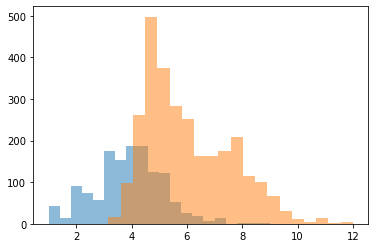

In [45]:
# additional analysis 4
# draw histgram of 'mean' grouped by is_deleted and visualize the difference
# https://qiita.com/supersaiakujin/items/be4a78809e7278c065e6
plt.hist(customer_end['mean'], bins = 20, alpha = 0.5)
plt.hist(customer_stay['mean'], bins = 20, alpha = 0.5)